# Distinguish between 4 different kinds of particles
## Problem : multi class classification
### Data :   simplified dataset of a GEANT based simulation of electron-proton inelastic scattering measured by a particle detector system.  https://www.kaggle.com/naharrison/particle-identification-from-detector-responses
<b> Explanatory variables <b/> :
* p - momentum (GeV/c)
* theta - theta (rad)
* beta - beta
* nphe - number of photoelectrons
* ein - inner energy (GeV)
* eout - outer energy (GeV)<br>
    
<b> Response variable <b/> : id - particle type:  <br>
* positron (-11)
* pion (211)
* kaon (321)
* proton (2212) <br>


In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.utils import shuffle
import scikitplot as skplt 

Using TensorFlow backend.


In [2]:
data=pd.read_csv('particle_data.csv')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [7]:
print('Data size: ', len(data))

Data size:  5000000


In [9]:
print('Are any missing data? ',data.isnull().values.any())

Are any missing data?  False


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 7 columns):
id       int64
p        float64
theta    float64
beta     float64
nphe     int64
ein      float64
eout     float64
dtypes: float64(5), int64(2)
memory usage: 267.0 MB


### Response variable

In [13]:
print('Categories of the response variable: ',data['id'].unique())

Categories of the response variable:  [ 211 2212  321  -11]


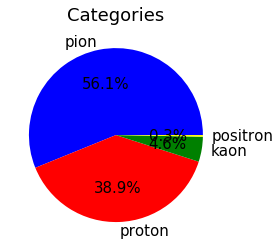

In [21]:
labels =   'pion' ,  'proton', 'kaon', 'positron'
out=data['id'].value_counts()
sizes = [out[211], out[2212], out[321],out[-11]]
colors = ['blue', 'red','green','yellow']
plt.rcParams['font.size'] = 15
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%')
plt.title('Categories')
plt.show()

### Explanatory variables

In [25]:
data[data.columns.difference(['id'])].describe()

,beta,ein,eout,nphe,p,theta
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.995796e-01,5.635883e-02,7.033195e-02,3.575243e+00,1.230053e+00,4.889321e-01
std,1.132321e-01,7.882675e-02,1.020604e-01,1.779236e+01,7.414895e-01,2.942161e-01
min,5.500010e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.101170e-01,9.222140e-02
25%,8.378760e-01,0.000000e+00,0.000000e+00,0.000000e+00,6.657510e-01,2.817420e-01
50%,9.461940e-01,3.442440e-02,4.417490e-02,0.000000e+00,1.066150e+00,4.048670e-01
75%,9.855910e-01,6.834520e-02,9.365990e-02,0.000000e+00,1.649650e+00,6.117800e-01
max,1.499590e+00,8.993820e-01,1.097410e+00,3.490000e+02,5.286950e+00,2.219270e+00


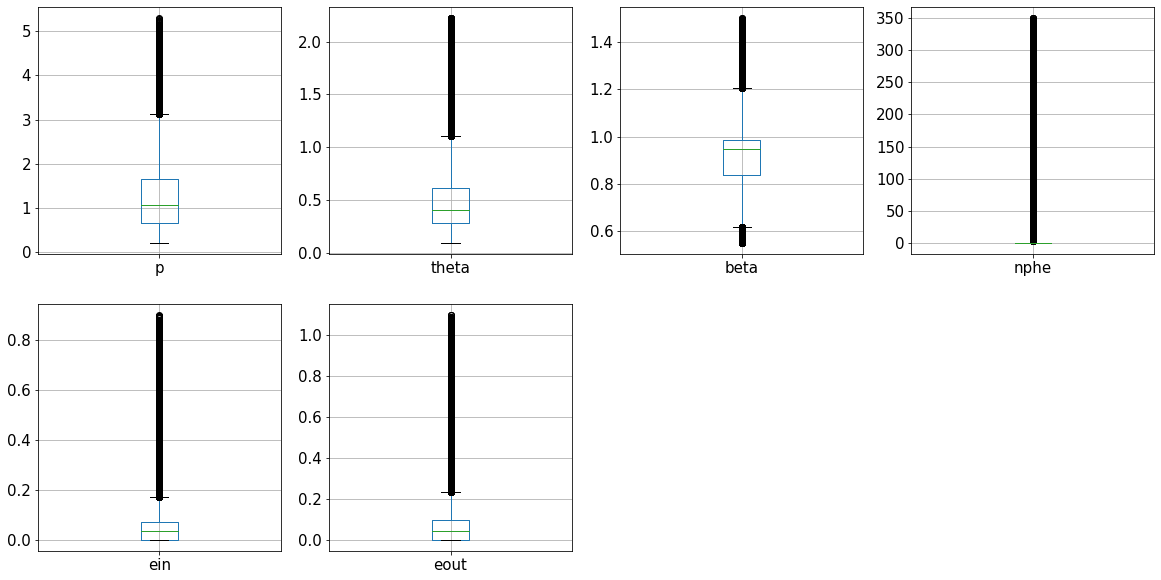

In [26]:
plt.figure(figsize=(20,10))
j=1
for i in data.columns:
    if i=='id': pass
    else:
        plt.subplot(2,4,j)
        data.boxplot(column=i)
        j+=1

Frequently skewed distribution; many, many outliers.

### Correlation of the explanatory variables

In [28]:
corr_matrix=data[data.columns.difference(['id'])].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,beta,ein,eout,nphe,p,theta
beta,1,-0.00895432,0.115911,0.0167361,0.226958,0.0185224
ein,-0.00895432,1,0.287848,-0.0208189,0.413338,-0.37005
eout,0.115911,0.287848,1,-0.040047,0.547105,-0.381239
nphe,0.0167361,-0.0208189,-0.040047,1,-0.0804242,0.0394622
p,0.226958,0.413338,0.547105,-0.0804242,1,-0.568578
theta,0.0185224,-0.37005,-0.381239,0.0394622,-0.568578,1


Explanatory variables are rather not correlated significantly between each other.

### Group comparison

In [29]:
grouped=data.groupby('id').mean()
grouped=grouped.transpose()
grouped

id,-11,211,321,2212
p,0.591886,1.035184,1.744734,1.454526
theta,0.471277,0.574035,0.381561,0.379136
beta,1.001011,0.968695,0.921961,0.796434
nphe,26.177948,4.636706,2.001605,2.059655
ein,0.068000,0.042600,0.060969,0.075566
eout,0.021495,0.052250,0.088638,0.094600


<b> Observations about means for the different categories: </b> <br>
* <b> p  - </b> seems to differ between groups.
* <b> theta - </b> the difference between 321 and 2212 is very slight. 
* <b> beta - </b> the difference not so notable. A bit lower for 2212.
* <b> nphe - </b> much higher for the group -11 than for the others. Different for 211 and similar between 321 and 2212.
* <b> ein - </b> very similar, slight difference for 211.
* <b> eout - </b> seems to rise depending on the group.

Text(0.5, 1.0, 'Mean comparison for the groups')

<Figure size 1440x1440 with 0 Axes>

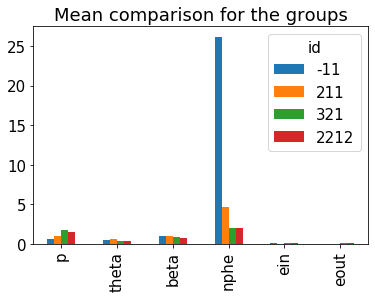

In [41]:
plt.figure(figsize=(20,20))
grouped.plot.bar()
plt.title('Mean comparison for the groups')

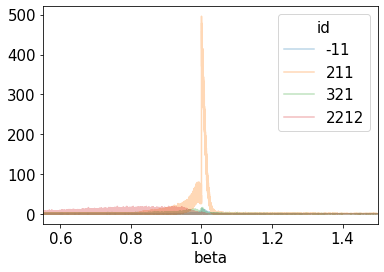

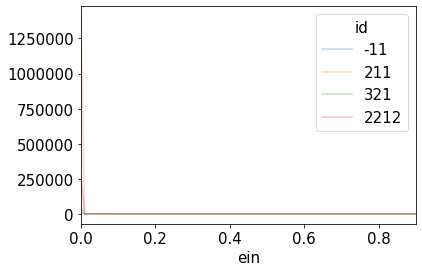

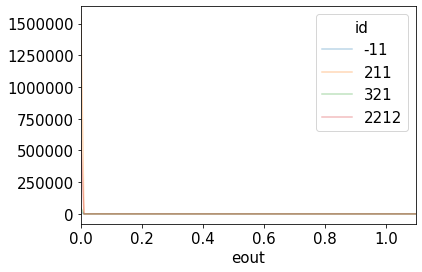

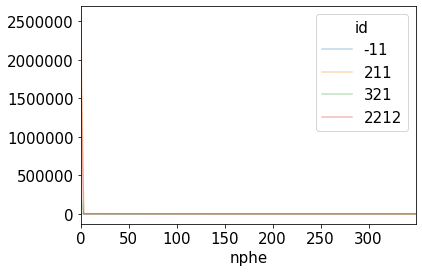

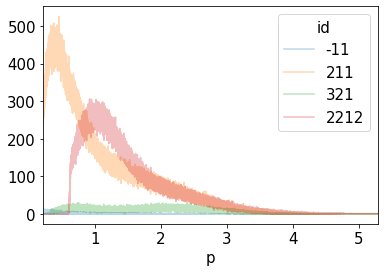

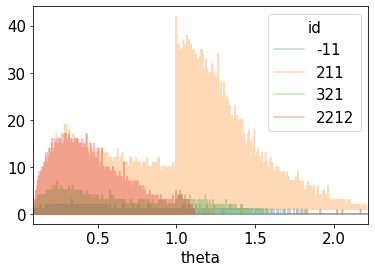

In [48]:
for i,j in zip(data.columns.difference(['id']), range(1, len(data.columns.difference(['id'])) +1) ):
    a=pd.crosstab(data[i],data['id'])#.plot(kind='line')
    a.plot(kind='line',alpha=0.3)

<b> Observations about means for the different categories: </b> <br>
* <b> p  - </b> takes rather low value if belongs to 211. Hgher for 2212. No singular pattern for -11 and 321.
* <b> theta - </b> for 321 and -11 the distribution is very scattered, no specific pattern. The majority of particles for 2212 group have theta below 1.  211 many particles between 1 and 1.5
* <b> beta - </b> if belongs to 211 then the value rather close to 1. No specific pattern for other groups.
* <b> nphe - </b> no specific observations.
* <b> ein - </b> no specific observations.
* <b> eout - </b> no specific observations.

# Logistic regression

## First model

In [5]:
# Data split 20% (test) - 80% (train)
from sklearn.utils import shuffle
data = shuffle(data)
X_train,X_test,Y_train,Y_test = train_test_split(data.drop('id',axis=1), data['id'],test_size=0.2,random_state=0)

In [ ]:
model=LogisticRegression()
model.fit(X_train,Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Analysis of the performance for the training data

In [52]:
predictions = model.predict(X_train)

In [53]:
#Predictions for X_train
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
print(classification_report(Y_train, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         -11       0.00      0.00      0.00     11887
         211       0.94      0.97      0.95   2245953
         321       0.00      0.00      0.00    185998
        2212       0.93      0.99      0.96   1556162

    accuracy                           0.93   4000000
   macro avg       0.47      0.49      0.48   4000000
weighted avg       0.89      0.93      0.91   4000000



In [54]:
print('Accuracy score = correct predictions / total number of predictions:',accuracy_score(Y_train, predictions))

Accuracy score = correct predictions / total number of predictions: 0.93198225


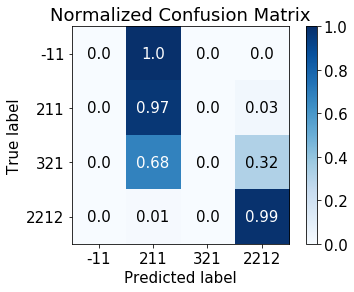

In [55]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(Y_train, predictions, normalize=True)

### Analysis of the performance for the testing data

In [56]:
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         -11       0.00      0.00      0.00      2960
         211       0.94      0.97      0.95    560880
         321       0.00      0.00      0.00     46473
        2212       0.93      0.99      0.96    389687

    accuracy                           0.93   1000000
   macro avg       0.47      0.49      0.48   1000000
weighted avg       0.89      0.93      0.91   1000000



In [57]:
print('Accuracy score = correct predictions / total number of predictions:',accuracy_score(Y_test, predictions))

Accuracy score = correct predictions / total number of predictions: 0.932299


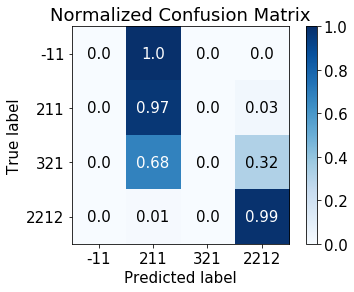

In [58]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True)

### Conclusions:
* model has a good overall accuracy, it can identify well 2212 group and 211 the most common types.
* sometimes it identifies correctly 321, it confuses it frequently with 2212 though.
* it almost never indentifies -11
* the observed predictions patterns are justified by the given data structure (few data about -11 comparing to the rest).
* can't indentify kaon and positron (because there are only few cases of it)

Maybe I should change the proportions between the group. Like 25% - 25% - 25% - 25%

# Second model
* <b> Training data </b> - each group has the same number of samples (size= size(of the smallest group)/2)
* <b> Testing data </b> - all other data not present in the training data

In [48]:
grouped=data.groupby('id')

In [11]:
print('size of the 211 group : ',len(grouped.get_group(211)))
print('size of the -11 group : ',len(grouped.get_group(-11)))
print('size of the 321 group : ',len(grouped.get_group(321)))
print('size of the 2212 group : ',len(grouped.get_group(2212)))

size of the 211 group :  2806833
size of the -11 group :  14847
size of the 321 group :  232471
size of the 2212 group :  1945849


In [92]:
g1=grouped.get_group(211)
g2=grouped.get_group(-11)
g3=grouped.get_group(321)
g4=grouped.get_group(2212)

size_of_the_group=int(14847/1.2)

g2_prim = g2.sample(n=size_of_the_group)
g1_prim = g1.sample(n=size_of_the_group)
g3_prim = g3.sample(n=size_of_the_group)
g4_prim = g4.sample(n=size_of_the_group)

In [93]:
from sklearn.utils import shuffle
frames = [g1_prim, g2_prim, g3_prim,g4_prim]
new_data = pd.concat(frames) #new data with equal fraction of data about every group
new_data = shuffle(new_data)

In [94]:
test_data=data[~data.isin(new_data)].dropna() # testing data are all data that didn t appear in the new data
test_data=shuffle(test_data)

In [95]:
X_train,Y_train = new_data.drop('id',axis=1), new_data['id'] 
X_test,Y_test = test_data.drop('id',axis=1), test_data['id']

In [96]:
model=LogisticRegression()
model.fit(X_train,Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
predictions = model.predict(X_train)

In [98]:
print('Accuracy score training data = correct predictions / total number of predictions:',accuracy_score(Y_train, predictions))

Accuracy score training data = correct predictions / total number of predictions: 0.7579211121888134


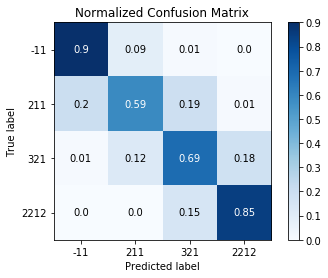

In [99]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(Y_train, predictions, normalize=True)

In [100]:
predictions = model.predict(X_test)

In [101]:
print('Accuracy score = correct predictions / total number of predictions:',accuracy_score(Y_test, predictions))

Accuracy score = correct predictions / total number of predictions: 0.6983170629623764


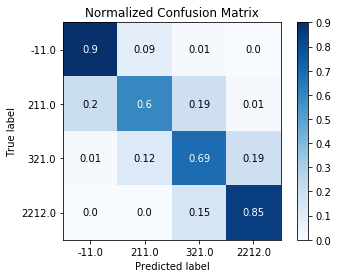

In [102]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True)

### Conclusions:
* Now it is capable to predict somehow each label. However the detection of 211 is significantly harder task than in the previous model. 
* Gained capacity to detect other labels is bought by the lower overall accuracy and lower probability of the correct detection of 211 and 2212.
* identifies well the most common type 2212 (proton), but the second most common type does not.

### Maybe the size of the group can change something?

In [104]:
for i in range(0,10):
    size=1+i/10
    size_of_the_group=int(14847/size)

    g2_prim = g2.sample(n=size_of_the_group)
    g1_prim = g1.sample(n=size_of_the_group)
    g3_prim = g3.sample(n=size_of_the_group)
    g4_prim = g4.sample(n=size_of_the_group)
    
    frames = [g1_prim, g2_prim, g3_prim,g4_prim]
    new_data = pd.concat(frames) #new data with equal fraction of data about every group
    new_data = shuffle(new_data)
    test_data=data[~data.isin(new_data)].dropna() # testing data are all data that didn t appear in the new data
    test_data=shuffle(test_data)
    X_train,Y_train = new_data.drop('id',axis=1), new_data['id'] 
    X_test,Y_test = test_data.drop('id',axis=1), test_data['id']
    
    model=LogisticRegression()
    model.fit(X_train,Y_train)
    
    predictions = model.predict(X_test)
    print('size: ', size,'Accuracy score',accuracy_score(Y_test, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.0 Accuracy score 0.7028076683617334


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.1 Accuracy score 0.6965549214195194


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.2 Accuracy score 0.6976702611770257


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.3 Accuracy score 0.6961738442409856


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.4 Accuracy score 0.696935198221713


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.5 Accuracy score 0.7002315132142356


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.6 Accuracy score 0.6926845358464957


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.7 Accuracy score 0.6934660310795341


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.8 Accuracy score 0.6897891044266488


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


size:  1.9 Accuracy score 0.6873894086714872


### Conclusion : group size doesn't seem to change anything in terms of accuracy

Maybe different proportions : instead of 25% x 4
maybe 30% 30% 30% and 10%